In [1]:
%matplotlib notebook

Another way of looking at the turn data is to take the distance (in mm) to the virtual white
light source. 

This is a different metric as the one shown in Fig 4G as the stimulus intensity does *not* scale
linearly with the distance!

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from glob import glob
import json
from scipy.spatial import distance
from scipy import stats
import matplotlib.patches as mpatches
import time
import scipy.signal as signal
from scipy.signal import argrelextrema, find_peaks
from scipy.ndimage import affine_transform
from scipy import stats
import pickle 
from skimage import draw
from pathlib import Path
import shared_functions
import statsmodels.api as sm

In [3]:
home_path = os.getcwd()
# set to True to save plot
save_plot = False

data_path = Path(home_path, 'data/gaussian_arena/')
data_path_ctr = Path(home_path, 'data/control/')
# all the figures will be saved in this folder
target_path = Path(home_path, 'plots/')
Path(target_path).mkdir(parents=True, exist_ok=True) 

In [4]:
def calc_orientation_to_light_func(path, control = False):
    """
    
    """
    folders = [x for x in path.iterdir() if x.is_dir()]

    arena_max_coordinates = np.zeros((2,len(folders)))
    all_counted_scoots = []
    all_angles_light = []
    all_angle = []
    all_angle_relative_to_light = []
    
    all_px_per_mm = np.zeros((len(folders)))


    # Go through each experimental folder, collect relevant data and calculate
    # distance to source
    for i, folder_name in enumerate(folders):
        print('Analyzing ' + folder_name.parts[-1])

        files = [x for x in folder_name.iterdir() if x.is_file()]

        # find the data_file.csv 
        for file in files:
            if 'data.csv' in file.parts[-1]:
                data = pd.read_csv(file)

        with open((Path(folder_name, 'experiment_settings.json')), 'r') as file:
            experiment_settings = json.load(file)
            fps = experiment_settings['Framerate']
            pixel_per_mm = experiment_settings['Pixel per mm']
        all_px_per_mm[i] = pixel_per_mm

        y = np.asarray(data['Y-Centroid'])
        x = np.asarray(data['X-Centroid'])

        if i == 0:
            centroid_coordinates = np.zeros((x.shape[0],2,len(folders)))
            all_centroid_coordinates_filt = np.zeros((x.shape[0],2,len(folders)))
        centroid_coordinates[:, 0, i] = y
        centroid_coordinates[:, 1, i] = x

        # filter x/y coordinates using the half-triangle
        centroid_filt_y =  np.floor(np.convolve(y,shared_functions.constants.kernel_centroid,'same'))
        centroid_filt_x =  np.floor(np.convolve(x,shared_functions.constants.kernel_centroid,'same'))
        centroid_filt = np.asarray((centroid_filt_y, centroid_filt_x)).T

        all_centroid_coordinates_filt[:,:,i]= centroid_filt
        # calculated speed using eucledian distance
        centroid_speed_filt = []
        for i_speed in range(centroid_filt.shape[0]):
            centroid_speed_filt.append((np.linalg.norm(centroid_filt[i_speed, :,] \
                                                       - centroid_filt[i_speed - 1,:] ) \
                                                       / pixel_per_mm) * fps)

        # list to numpy array:
        centroid_speed_filt = np.asarray(centroid_speed_filt)
        # convolve to do the triangular filtering (2nd filtering)
        filt_centroid_speed_filt =  np.convolve(centroid_speed_filt,
                                                shared_functions.constants.kernel_speed,
                                                'same')


        if i == 0:
            filtered_speed_np = np.zeros((len(centroid_filt), len(folders)))

        filtered_speed_np[:,i] = np.asarray(filt_centroid_speed_filt).copy()

        # In control experiments no virtual arena was saved - need to reconstruct post-hoc what the arena
        # would have looked like
        virtual_arena = None
        if control:
            data_first_frame = []
            with (open(Path(folder_name, 'first_frame_data.pkl'), 'rb')) as openfile:
                while True:
                    try:
                        data_first_frame.append(pickle.load(openfile))
                    except EOFError:
                        break
            # adjust the arena according to the first frame
            virtual_arena = shared_functions.adjust_VR_arena_to_animal(data_first_frame, 
                                                                       centroid_coordinates[:,:,i],
                                                                       home_path)
        # In experiment condition, just read the used virtual arena
        else:
            # get the arena
            for file in files:
                if 'csv' and '640x480' in file.parts[-1]:
                    virtual_arena = np.genfromtxt(file, delimiter=',')

        # Get the maximum xy coordinate of the arena (different for different experiment as it depends on the position of 
        # the animal)
        max_arena_indices = np.where(virtual_arena == np.amax(virtual_arena))
        # just the the first one as there are only two anyways and it's only used to center the image
        arena_max_coordinates[:,i] = max_arena_indices[0][0], max_arena_indices[1][0]

        # finding peaks - just use the supplied scipy function directly on the array
        identified_scoots,temp = find_peaks(x = filtered_speed_np[:,i],
                                            height = shared_functions.constants.speed_scoot,
                                            distance = shared_functions.constants.min_frames_between_scoots,
                                            width = shared_functions.constants.minimum_length_of_scoot
                                 )
        #all_scoots.append(identified_scoots)

        # next, calculate orientation during scoot relative to light source
        # use the following three points:
        # 1) the x and y position ~100ms before the scoot maximum
        # 2) the x and y position ~100ms after the scoot maximum
        # 3) the x and y position of the source
        #
        # First, calculate the (absolute) angle of the animal by defining the angle of the scoot:
        # angle_animal = after - before
        # Second, calculate the angle between the position ~100ms after the scoot (heading/front) and the source:
        # source - after
        # angle_front_source = then simply subtract the angle_front_source from angle_animal

        y_source = arena_max_coordinates[0,i]
        x_source = arena_max_coordinates[1,i]

        all_counted_scoots_temp, all_angles_light_temp,angles_rel_to_light_temp, \
            all_angle_temp, not_counted_scoots \
                =shared_functions.define_counted_scoots(
                            identified_peaks=identified_scoots,
                             scoot_time=shared_functions.constants.scoot_time,
                             centroid_coords=centroid_coordinates[:,:,i],
                             y_source=y_source,
                             x_source=x_source)

        all_counted_scoots.append(all_counted_scoots_temp)

        all_angles_light.append(all_angles_light_temp)

        all_angle_relative_to_light.append(np.asarray(angles_rel_to_light_temp))

        all_angle.append(all_angle_temp)
    
    return(all_angle,
           arena_max_coordinates,
           all_centroid_coordinates_filt,
           all_counted_scoots,
           all_px_per_mm # only a single one is used anyway
          )


In [5]:
phi_exp, source_coordinates_exp, centroid_coordinates_exp, scoots_exp, pixel_per_mm_exp = \
        calc_orientation_to_light_func(data_path)

Analyzing 01.07.2018_12-24-50_Casper AB


C:\Users\David\AppData\Local\conda\conda\envs\pivr_publication\lib\site-packages\ipykernel_launcher.py:101: PeakPropertyWarning: some peaks have a width of 0


Analyzing 01.07.2018_14-25-37_Casper AB
Analyzing 01.07.2018_14-56-01_Casper AB
Analyzing 01.07.2018_15-15-17_Casper AB
Analyzing 01.07.2018_15-21-37_Casper AB
Analyzing 01.07.2018_15-31-53_Casper AB
Analyzing 01.07.2018_15-45-35_Casper AB
Analyzing 01.07.2018_16-28-07_Casper AB
Analyzing 01.07.2018_16-38-07_Casper AB
Analyzing 01.07.2018_16-56-10_Casper AB
Analyzing 01.07.2018_17-05-04_Casper AB
Analyzing 01.07.2018_18-16-36_Casper AB
Analyzing 01.07.2018_18-49-55_Casper AB


In [6]:
phi_ctr, source_coordinates_ctr, centroid_coordinates_ctr, scoots_ctr, pixel_per_mm_ctr = \
        calc_orientation_to_light_func(data_path_ctr, control=True)

Analyzing 01.07.2018_19-08-12_Casper AB


C:\Users\David\AppData\Local\conda\conda\envs\pivr_publication\lib\site-packages\ipykernel_launcher.py:101: PeakPropertyWarning: some peaks have a width of 0


Analyzing 01.07.2018_20-23-12_Casper AB
Analyzing 01.07.2018_20-16-58_Casper AB
Analyzing 01.07.2018_20-11-27_Casper AB
Analyzing 01.07.2018_20-01-43_Casper AB
Analyzing 01.07.2018_19-53-46_Casper AB
Analyzing 01.07.2018_19-44-51_Casper AB
Analyzing 01.07.2018_19-37-48_Casper AB
Analyzing 01.07.2018_19-26-50_Casper AB
Analyzing 01.07.2018_19-22-20_Casper AB
Analyzing 01.07.2018_19-13-46_Casper AB


In [7]:
# Turn angle binned how far away from source
# To do this correctly (with stats)  I need to bin the distance (e.g 0-5) and normalize for each experiment
def angle_relative_to_distance(all_angles,
                              arena_center,
                              centroids,
                               scoots,
                              px_per_mm):
    # collect all the distances
    distance_to_source = []
    max_distance = 40
    # CALCULATE THE DISTANCE OF EACH SCOOT TO THE SOURCE
    for i_experiment in range(len(all_angles)):
        x_1 = arena_center[1,i_experiment]
        y_1 = arena_center[0,i_experiment]
        # calculate for each scoot the distance to the source
        temp_dist = []
        for i_scoot in range(len(all_angles[i_experiment])):
            x_2 = centroids[scoots[i_experiment][i_scoot],1,i_experiment]
            y_2 = centroids[scoots[i_experiment][i_scoot],0,i_experiment]
            temp_dist.append(np.sqrt(((x_1-x_2)**2)+((y_1-y_2)**2))/px_per_mm[i_experiment])
            #if temp_dist[-1] > max_distance:
            #    max_distance=temp_dist[-1]
        distance_to_source.append(temp_dist)

                                                 
    # BIN THE DISTANCES 
    bin_number = 4
    bin_one = []
    bin_two = []
    bin_three = []
    bin_four = []
    bin_five = []
    mean_angle_relative_to_distance = np.zeros((bin_number,len(distance_to_source)))
    mean_angle_relative_to_distance.fill(np.nan)

    #What is the NEXT absolute turn angle?
    abs_angle_cor = shared_functions.transpose_angle_to_2pi(all_angles)
    for i_experiment in range(len(distance_to_source)):
        bin_one_temp = []
        bin_two_temp = []
        bin_three_temp = []
        bin_four_temp = []
        bin_five_temp = []
        turn_angle = []
        for i_angle in range(1,len(abs_angle_cor[i_experiment])):
            turn_angle.append(shared_functions.calc_angle_diff_2(abs_angle_cor[i_experiment][i_angle], 
                                              abs_angle_cor[i_experiment][i_angle-1]))
        

        for i_scoot in range(len(distance_to_source[i_experiment])-1):
                if distance_to_source[i_experiment][i_scoot] <= max_distance/bin_number*1:
                    bin_one_temp.append(abs(turn_angle[i_scoot]))
                elif distance_to_source[i_experiment][i_scoot] <= max_distance/bin_number*2:
                    bin_two_temp.append(abs(turn_angle[i_scoot]))
                elif distance_to_source[i_experiment][i_scoot] <= max_distance/bin_number*3: 
                    bin_three_temp.append(abs(turn_angle[i_scoot]))
                elif distance_to_source[i_experiment][i_scoot] <= max_distance/bin_number*4: 
                    bin_four_temp.append(abs(turn_angle[i_scoot]))
                elif distance_to_source[i_experiment][i_scoot] <= max_distance/bin_number*5: 
                    bin_five_temp.append(abs(turn_angle[i_scoot]))

        bin_one.append(bin_one_temp)
        bin_two.append(bin_two_temp)
        bin_three.append(bin_three_temp)
        bin_four.append(bin_four_temp)
        bin_five.append(bin_five_temp)

        mean_angle_relative_to_distance[0,i_experiment] = np.nanmean(np.asarray(bin_one_temp))
        mean_angle_relative_to_distance[1,i_experiment] = np.nanmean(np.asarray(bin_two_temp))
        mean_angle_relative_to_distance[2,i_experiment] = np.nanmean(np.asarray(bin_three_temp)) 
        mean_angle_relative_to_distance[3,i_experiment] = np.nanmean(np.asarray(bin_four_temp))
        #median_angle_relative_to_distance[4,i_experiment] = np.nanmedian(np.asarray(bin_five_temp))
        
    fig=plt.figure()
    ax=fig.add_subplot(111)
    for i in range(bin_number):
        ax.boxplot(np.rad2deg(
            mean_angle_relative_to_distance[i,~np.isnan(mean_angle_relative_to_distance[i,:])]),positions=[i])

    ax.set_xlim(-1,bin_number)
    
    return(mean_angle_relative_to_distance, distance_to_source)

C:\Users\David\AppData\Local\conda\conda\envs\pivr_publication\lib\site-packages\ipykernel_launcher.py:71: RuntimeWarning: Mean of empty slice


<IPython.core.display.Javascript object>


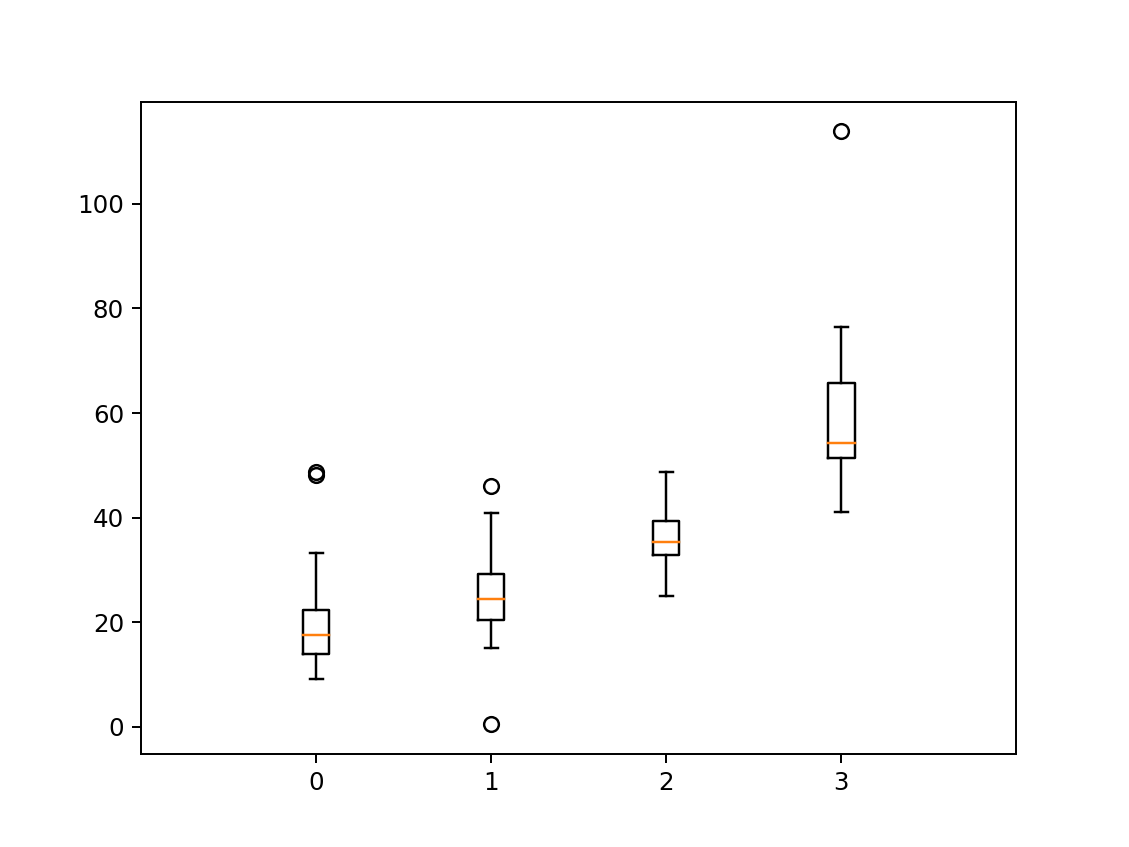

In [8]:
mean_angles_relative_to_distance_exp, temp = angle_relative_to_distance(phi_exp,
                                                                      source_coordinates_exp,
                                                                      centroid_coordinates_exp,
                                                                      scoots_exp,
                                                                      pixel_per_mm_exp)


<IPython.core.display.Javascript object>


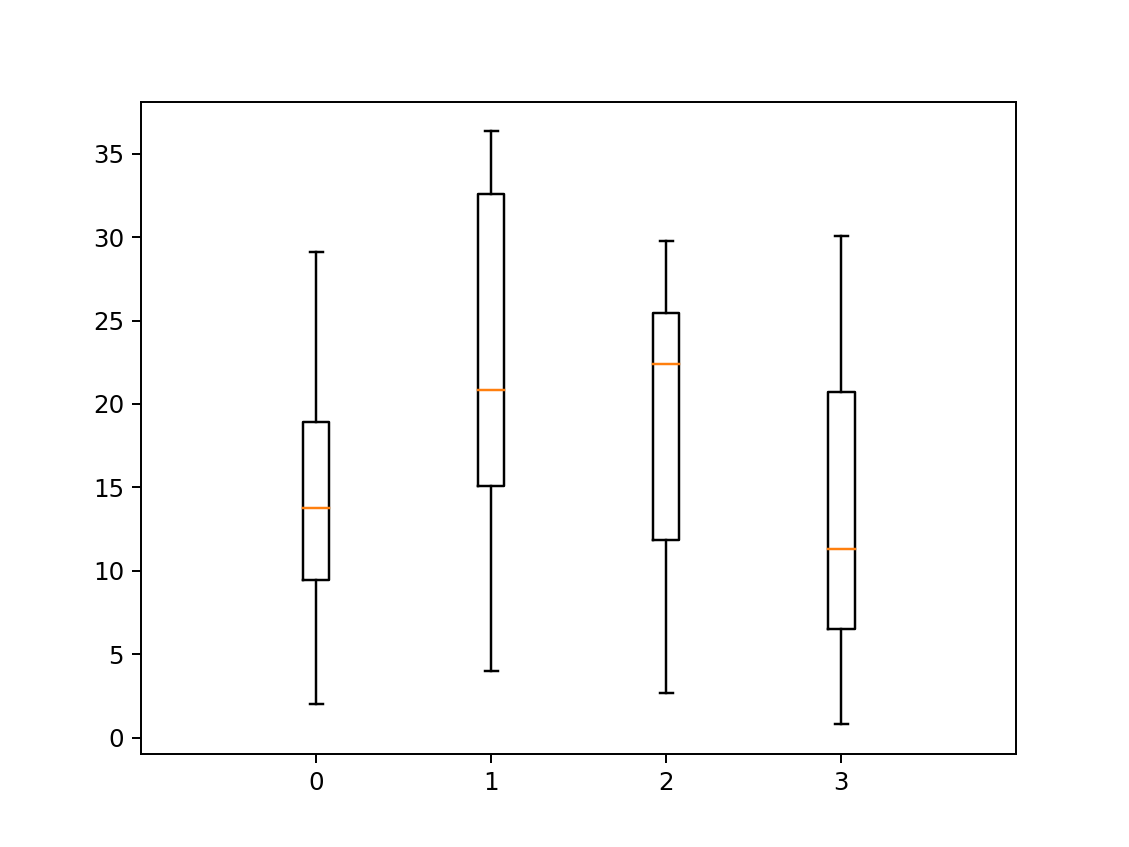

In [9]:
mean_angles_relative_to_distance_ctr, temp = angle_relative_to_distance(phi_ctr,
                                                                      source_coordinates_ctr,
                                                                      centroid_coordinates_ctr,
                                                                      scoots_ctr,
                                                                      pixel_per_mm_ctr)


<IPython.core.display.Javascript object>


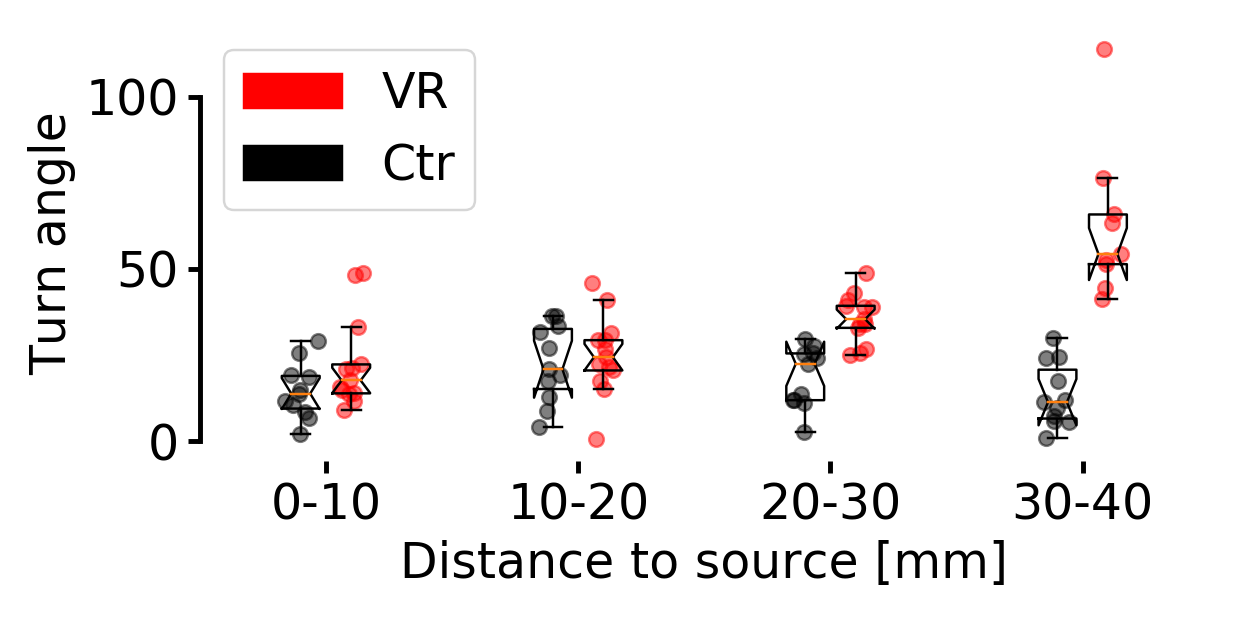

Bonferroni for 0.001 for four samples: 0.00025

Lilliefors exp: 0.008695695921540805 Lilliefors ctr: 0.2
LeveneResult(statistic=0.6101730687165627, pvalue=0.4430477993997298)
RanksumsResult(statistic=1.593255013631383, pvalue=0.11110299424196111)

Lilliefors exp: 0.2 Lilliefors ctr: 0.2
LeveneResult(statistic=0.17040560240759828, pvalue=0.6837470118372644)
RanksumsResult(statistic=0.37658754867650873, pvalue=0.7064801424026955)

Lilliefors exp: 0.2 Lilliefors ctr: 0.2
LeveneResult(statistic=0.9050411581592731, pvalue=0.3517691173845635)
RanksumsResult(statistic=3.6210341218895072, pvalue=0.0002934278077338184)

Lilliefors exp: 0.2 Lilliefors ctr: 0.2
LeveneResult(statistic=1.5459553107727624, pvalue=0.22968505360462313)
RanksumsResult(statistic=3.760699023168052, pvalue=0.00016943920219370635)


In [10]:

fig=plt.figure('Turn Angle relative to Distance',figsize=(7,3.5))
ax=fig.add_subplot(111)
ax.set_rasterization_zorder(1)

for i in range(mean_angles_relative_to_distance_ctr.shape[0]):
    # plot control
    data_ctr = mean_angles_relative_to_distance_ctr[i,~np.isnan(mean_angles_relative_to_distance_ctr[i,:])]
    ax.boxplot(np.rad2deg(data_ctr),
              positions=[i-0.1], showfliers=False, notch =True, zorder=1)
    x_ctr = np.random.normal(i-0.1, 0.03, size=data_ctr.shape[0])
    ax.scatter(x=x_ctr,
              y=np.rad2deg(data_ctr),
              alpha=0.5,
              color='k',zorder=0)
    
    # plot exp
    data_exp = mean_angles_relative_to_distance_exp[i,~np.isnan(mean_angles_relative_to_distance_exp[i,:])]
    boxplot = ax.boxplot(np.rad2deg(data_exp),
                         positions=[i+0.1], 
                         showfliers=False, 
                         notch =True, 
                         #patch_artist=True,
                         zorder=1)
    # color the boxplot
    #boxplot['boxes'][0].set_facecolor('red')
    x_exp = np.random.normal(i+0.1, 0.03, size=data_exp.shape[0])
    ax.scatter(x=x_exp, 
               y=np.rad2deg(data_exp),
              alpha=0.5,
              color='r',zorder=0)
    if i == 0:
        print('Bonferroni for 0.001 for four samples: '+ repr(0.001/4))
    print("\nLilliefors exp: " + repr(sm.stats.lilliefors(data_exp)[1]),
         "Lilliefors ctr: " + repr(sm.stats.lilliefors(data_ctr)[1]))
    print(repr(stats.levene(data_exp,
                            data_ctr)))
    
    print(stats.ranksums(data_exp,
                          data_ctr))
    # MUST do parametric as the first lififors test is significant!
    #print(stats.ttest_ind(data_exp,
    #                     data_ctr))

ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels(['0-10','10-20','20-30','30-40'])
ax.set_xlim(-0.5,mean_angles_relative_to_distance_ctr.shape[0]-0.5)
# Can change ticklabel size here, if necessary!
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='x',which='major',bottom='off')

ax.set_ylabel('Turn angle', fontsize=20)
# Only draw spine between the y-ticks
ax.spines['left'].set_bounds(0, 100)
# Can change ticklabel size here, if necessary!
ax.tick_params(axis='y', labelsize=20)
ax.set_xlabel('Distance to source [mm]', fontsize=20)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_linewidth(2)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', width=2, length =5)
ax.tick_params(axis='both', which='minor', width =2,length =3)

# make some patches for the legend
red_circle = mpatches.Circle((0,0),color='red', label='VR')
black_circle = mpatches.Circle((0,0),color='k', label='Ctr')
ax.legend(handles=[red_circle,black_circle],fontsize=20, loc=2)

#ax.grid(which='major', axis='y', linestyle='--', alpha = 0.5, zorder=0)

fig.tight_layout()

if save_plot:
    fig.savefig(Path(target_path, 'Fig4S8c.eps'), rasterized=True, dpi=300)